<a href="https://colab.research.google.com/github/DianaMeda/AI-Literacy/blob/main/4_2_Journal_names.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import json
import re
import time
from pathlib import Path
from urllib.parse import quote
import gdown
import pandas as pd
import requests
import time
from difflib import SequenceMatcher
from urllib.parse import quote
from tqdm import tqdm
import os

from pathlib import Path
from difflib import SequenceMatcher
from urllib.parse import quote

In [2]:
from google.colab import drive

drive.mount('/content/drive')

folder_url = "https://drive.google.com/drive/folders/1vx3IolDNtoBaU_TM3uUHGXN6QQqOkd9v?usp=drive_link"

local_root = "/content/review_data"

gdown.download_folder(folder_url, output=local_root, quiet=False)
print(os.listdir(local_root))

Mounted at /content/drive


Retrieving folder contents


Processing file 1m8HcyK-ytQxSdj3HNQP_OXm_OBcf7Fw3 ALL_items_with_official_title.csv
Processing file 1nE3h-mu9L1jWpyvN8O73m2E3r2aowKy9 cleaned_data.csv
Processing file 1lowh10G-oMHGwYrfhEaaXmLqzo2ntaGR list of AI review articles.csv
Processing file 17Kwr-R3cz1DdE371O3nckdhs6CqvARtr new_list.csv
Processing file 1iG2B03nWxsixhWjw5p2gi6d5_TDCpx24 old_list.csv
Processing file 1wT4N7bCwQgYk91DRsK6duMm4vzUifCjZ search strings covidence.csv


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1m8HcyK-ytQxSdj3HNQP_OXm_OBcf7Fw3
To: /content/review_data/ALL_items_with_official_title.csv
100%|██████████| 3.96M/3.96M [00:00<00:00, 11.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1nE3h-mu9L1jWpyvN8O73m2E3r2aowKy9
To: /content/review_data/cleaned_data.csv
100%|██████████| 2.95M/2.95M [00:00<00:00, 20.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1lowh10G-oMHGwYrfhEaaXmLqzo2ntaGR
To: /content/review_data/list of AI review articles.csv
100%|██████████| 415k/415k [00:00<00:00, 5.35MB/s]
Downloading...
From: https://drive.google.com/uc?id=17Kwr-R3cz1DdE371O3nckdhs6CqvARtr
To: /content/review_data/new_list.csv
100%|██████████| 1.66M/1.66M [00:00<00:00, 4.79MB/s]
Downloading...
From: https://drive.google.com/uc?id=1iG2B03nWxsixhWjw5p2gi6d5_TDCpx24
To: /content/review_data/old_list.csv
100%|██████████| 479k/

['list of AI review articles.csv', 'ALL_items_with_official_title.csv', 'old_list.csv', 'cleaned_data.csv', 'search strings covidence.csv', 'new_list.csv']



Download completed


In [56]:
File_1 = os.path.join(local_root, "old_list.csv")
File_2 = os.path.join(local_root, "new_list.csv")
merged_file = os.path.join(local_root, "merged_list.csv")

def merge_two_csvs_on_all_columns(file1: str, file2: str) -> pd.DataFrame:
    df1 = pd.read_csv(file1)
    df2 = pd.read_csv(file2)

    all_cols = sorted(set(df1.columns) | set(df2.columns))

    df1 = df1.reindex(columns=all_cols)
    df2 = df2.reindex(columns=all_cols)

    merged = pd.concat([df1, df2], ignore_index=True)
    merged = merged.drop_duplicates(subset=all_cols, keep="first").reset_index(drop=True)

    return merged

df = merge_two_csvs_on_all_columns(File_1, File_2)
df.to_csv(merged_file, index=False)

In [57]:
merged_file = pd.read_csv(merged_file)
len(merged_file)

996

In [59]:
merged_file['DOI'].nunique(), merged_file['Key'].nunique()

(855, 996)

In [5]:
all_merged_file = os.path.join(local_root, "ALL_items_with_official_title.csv")
len(all_merged_file)

54

In [6]:
df.columns

Index(['Abstract Note', 'Access Date', 'Application Number', 'Archive',
       'Archive Location', 'Artwork Size', 'Assignee', 'Attorney Agent',
       'Author', 'Automatic Tags', 'Book Author', 'Call Number', 'Cast Member',
       'Code', 'Code Number', 'Commenter', 'Committee', 'Composer',
       'Conference Name', 'Contributor', 'Cosponsor', 'Counsel', 'Country',
       'Court', 'DOI', 'Date', 'Date Added', 'Date Modified', 'Edition',
       'Editor', 'Extra', 'File Attachments', 'Filing Date', 'Guest',
       'History', 'ISBN', 'ISSN', 'Interviewer', 'Issue', 'Issuing Authority',
       'Item Type', 'Journal Abbreviation', 'Key', 'Language', 'Legal Status',
       'Legislative Body', 'Library Catalog', 'Link Attachments',
       'Manual Tags', 'Medium', 'Meeting Name', 'Notes', 'Num Pages', 'Number',
       'Number Of Volumes', 'Pages', 'Place', 'Priority Numbers', 'Producer',
       'Programming Language', 'Publication Title', 'Publication Year',
       'Publisher', 'Recipient', '

In [7]:
item_type_counts = df["Item Type"].value_counts()
print(item_type_counts)

Item Type
journalArticle     796
conferencePaper    156
bookSection         43
book                 1
Name: count, dtype: int64


1. Preliminary counts per type of article

In [8]:
df_journal = df[df["Item Type"] == 'journalArticle']
df_conference = df[df["Item Type"] == 'conferencePaper']
df_book = df[(df["Item Type"] == 'bookSection') | (df["Item Type"] == 'book')]

In [9]:
df_journal[df_journal["Publication Title"].isna()][['Title', 'Author']]

print('Journals without a Publication Title', len(df_journal[df_journal["Publication Title"].isna()]))
print('Journals with a Publication Title', len(df_journal[df_journal["Publication Title"].notna()]))
print('Unique journals', df_journal[df_journal["Publication Title"].notna()]["Publication Title"].nunique())

unique_journal_titles = df_journal[df_journal["Publication Title"].notna()]["Publication Title"].unique().tolist()
#print("List of unique journal titles:")
#for title in unique_journal_titles:
#    print(title)

journal_article_missing_title = df_journal[df_journal["Publication Title"].isna()]

title = journal_article_missing_title.iloc[0]['Title']
author = journal_article_missing_title.iloc[0]['Author']

print(f"Article without Publication title: {author}, {title}")

Journals without a Publication Title 1
Journals with a Publication Title 795
Unique journals 469
Article without Publication title: nan, Educational Technology & Society


In [10]:
df_conference[df_conference["Publication Title"].isna()][['Title', 'Author']]

print('Conference Paper without a Publication Title', len(df_conference[df_conference["Publication Title"].isna()]))
print('Conference Paper with a Publication Title', len(df_conference[df_conference["Publication Title"].notna()]))
print('Unique Conference Paper', df_conference[df_conference["Publication Title"].notna()]["Publication Title"].nunique())

unique_conference_titles = df_conference[df_conference["Publication Title"].notna()]["Publication Title"].unique().tolist()

Conference Paper without a Publication Title 137
Conference Paper with a Publication Title 19
Unique Conference Paper 19


In [11]:
df_book[df_book["Publication Title"].isna()][['Title', 'Author']]

print('Book without a Publication Title', len(df_book[df_book["Publication Title"].isna()]))
print('Book with a Publication Title', len(df_book[df_book["Publication Title"].notna()]))
print('Unique Book', df_book[df_book["Publication Title"].notna()]["Publication Title"].nunique())

unique_book_titles = df_book[df_book["Publication Title"].notna()]["Publication Title"].unique().tolist()

Book without a Publication Title 1
Book with a Publication Title 43
Unique Book 29


2. CrossRef

In [12]:
DOI_COL_CANDIDATES = ["DOI", "doi", "Doi"]
PUBLICATION_TITLE_COL = "Publication Title"
ITEM_TYPE_COL = "Item Type"
NEW_JOURNAL_COL = "Journal_official"

CACHE_FILE = "doi_journal_cache.json"
USE_CACHE = True

CROSSREF_USER_AGENT = "JournalNameCleaner/1.0 (mailto:dianameda.rh@gmail.com)"
SLEEP_SECONDS = 0.1

STOP_WORDS = set("""a an and as at but by en for if in of on or the to up via vs vs. with without nor per""".split())

TYPE_MAP = {
    "JournalArticle": "journal-article",
    "journalArticle": "journal-article",
    "conferencePaper": "proceedings-article",
    "book": "book",
    "bookSection": "book-chapter",
}

In [13]:
def edit_title(text: str) -> str:
  """Title with lowercase stopwords, capital first letter"""
  s = str(text).strip()
  if not s:
    return s

  parts = re.split(r"(\s+)", s)  # keep spaces
  word_idx = [i for i, tok in enumerate(parts) if not tok.isspace()]

  def cap_token(tok: str, is_first: bool, is_last: bool) -> str:
    if not re.search(r"[A-Za-z0-9]", tok):
      return tok
    # Preserve ALLCAPS acronyms (2+ chars)
    if re.fullmatch(r"[A-Z0-9]{2,}", tok):
      return tok

    hy = tok.split("-")   #hyphenated words
    out = []
    for j, p in enumerate(hy):
      if not p:
        out.append(p)
        continue
      low = p.lower()
      if (low in STOP_WORDS) and not (is_first and j == 0) and not (is_last and j == len(hy) - 1):
        out.append(low)
      elif re.fullmatch(r"[A-Z0-9]{2,}", p):
        out.append(p)
      else:
        out.append(low[:1].upper() + low[1:])
    return "-".join(out)

  for k, i in enumerate(word_idx):
    parts[i] = cap_token(parts[i], is_first=(k == 0), is_last=(k == len(word_idx) - 1))

  return "".join(parts)



def crossref_journal_title(doi: str, session: requests.Session) -> str | None:
    """Return official journal title from Crossref container-title."""
    if not doi:
        return None
    url = f"https://api.crossref.org/works/{quote(doi)}"
    r = session.get(url, timeout=20)
    if r.status_code == 404:
        return None
    r.raise_for_status()

    msg = r.json().get("message", {}) # meta data store
    container = msg.get("container-title") or []
    if isinstance(container, list):
        for t in container:
            if t and str(t).strip():
                return str(t).strip()
    elif isinstance(container, str) and container.strip():
        return container.strip()
    return None

def load_cache(path: str) -> dict:
    p = Path(path)
    if p.exists():
        try:
            return json.loads(p.read_text(encoding="utf-8"))
        except Exception:
            return {}
    return {}

def save_cache(path: str, cache: dict) -> None:
    Path(path).write_text(json.dumps(cache, ensure_ascii=False, indent=2), encoding="utf-8")

def pick_doi_column(df: pd.DataFrame, candidates: list[str]) -> str | None:
  """Picks the first column from dataframe that matches the column candidates for DOI"""
  cols_lower = {c.lower(): c for c in df.columns}
  for c in candidates:
    if c in df.columns:
      return c
    if c.lower() in cols_lower:
      return cols_lower[c.lower()]
  return None

def add_official_journal_column(df: pd.DataFrame) -> pd.DataFrame:
  doi_col = pick_doi_column(df, DOI_COL_CANDIDATES)
  df["DOI_norm"] = df[doi_col]

  if NEW_JOURNAL_COL not in df.columns:
    df[NEW_JOURNAL_COL] = pd.NA

  session = requests.Session()
  session.headers.update({"User-Agent": CROSSREF_USER_AGENT})

  cache = load_cache(CACHE_FILE) if USE_CACHE else {}
  looked_up = 0
  filled = 0

  for idx, doi in tqdm(df["DOI_norm"].items(), total=len(df), desc="Looking up official journal"):
    if not doi:
      continue

    if USE_CACHE and doi in cache:
      official = cache[doi]
    else:
      looked_up += 1
      try:
        official = crossref_journal_title(doi, session)
      except Exception:
        official = None
      if USE_CACHE:
        cache[doi] = official
      time.sleep(SLEEP_SECONDS)

    if official:
      df.at[idx, NEW_JOURNAL_COL] = edit_title(official)
      filled += 1

  if USE_CACHE:
    save_cache(CACHE_FILE, cache)

  print(f"Filled '{NEW_JOURNAL_COL}' for {filled} rows (Crossref lookups not cached: {looked_up}).")
  return df

In [14]:
if __name__ == "__main__":
      output_journals = os.path.join(local_root, "journalArticle_with_official_Publication_Title.csv")
      df_journal_with_official_title = add_official_journal_column(df_journal)
      df_journal_with_official_title.to_csv(output_journals, index=False)

      output_conference = os.path.join(local_root, "conferencePaper_with_official_Publication_Title.csv")
      df_conference_with_official_title = add_official_journal_column(df_conference)
      df_journal_with_official_title.to_csv(output_conference, index=False)

      output_book = os.path.join(local_root, "book_with_official_Publication_Title.csv")
      df_book_with_official_title = add_official_journal_column(df_book)
      df_book_with_official_title.to_csv(output_book, index=False)


/tmp/ipython-input-2452612942.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["DOI_norm"] = df[doi_col]
/tmp/ipython-input-2452612942.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[NEW_JOURNAL_COL] = pd.NA
Looking up official journal: 100%|██████████| 796/796 [02:12<00:00,  6.01it/s]
/tmp/ipython-input-2452612942.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

Filled 'Journal_official' for 737 rows (Crossref lookups not cached: 723).


Looking up official journal: 100%|██████████| 156/156 [00:24<00:00,  6.34it/s]
/tmp/ipython-input-2452612942.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["DOI_norm"] = df[doi_col]
/tmp/ipython-input-2452612942.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[NEW_JOURNAL_COL] = pd.NA


Filled 'Journal_official' for 142 rows (Crossref lookups not cached: 134).


Looking up official journal: 100%|██████████| 44/44 [00:00<00:00, 433.02it/s]


Filled 'Journal_official' for 0 rows (Crossref lookups not cached: 1).


In [15]:
df_journal_with_official_title[df_journal_with_official_title["Journal_official"].isna()][['Title', 'Author']]

print('Journals without an official Publication Title', len(df_journal_with_official_title[df_journal_with_official_title["Journal_official"].isna()]))
print('Journals with an official Publication Title', len(df_journal_with_official_title[df_journal_with_official_title["Journal_official"].notna()]))
print('Unique official journals', df_journal_with_official_title[df_journal_with_official_title["Journal_official"].notna()]["Journal_official"].nunique())

unique_journal_titles = df_journal_with_official_title[df_journal_with_official_title["Journal_official"].notna()]["Journal_official"].unique().tolist()
#print("List of unique journal titles:")
#for title in unique_journal_titles:
#    print(title)

journal_article_missing_title = df_journal_with_official_title[df_journal_with_official_title["Journal_official"].isna()]


Journals without an official Publication Title 59
Journals with an official Publication Title 737
Unique official journals 332


In [16]:
print('Conference Papers without an official Publication Title', len(df_conference_with_official_title[df_conference_with_official_title["Journal_official"].isna()]))
print('Conference Papers with an official Publication Title', len(df_conference_with_official_title[df_conference_with_official_title["Journal_official"].notna()]))
print('Unique official conference papers', df_conference_with_official_title[df_conference_with_official_title["Journal_official"].notna()]["Journal_official"].nunique())

Conference Papers without an official Publication Title 14
Conference Papers with an official Publication Title 142
Unique official conference papers 89


In [17]:
print('Books without an official Publication Title', len(df_book_with_official_title[df_book_with_official_title["Journal_official"].isna()]))
print('Books with an official Publication Title', len(df_book_with_official_title[df_book_with_official_title["Journal_official"].notna()]))
print('Unique official books', df_book_with_official_title[df_book_with_official_title["Journal_official"].notna()]["Journal_official"].nunique())

Books without an official Publication Title 44
Books with an official Publication Title 0
Unique official books 0


Before vs After CrossRef

In [18]:
print('Journals with a Publication Title before CrossRef lookup:', df_journal['Publication Title'].notna().sum())
print('Conference Papers with a Publication Title before CrossRef lookup:', df_conference['Publication Title'].notna().sum())
print('Books with a Publication Title before CrossRef lookup:', df_book['Publication Title'].notna().sum())

print('Journals with an official Publication Title after CrossRef lookup:', df_journal_with_official_title['Journal_official'].notna().sum())
print('Conference Papers with an official Publication Title after CrossRef lookup:', df_conference_with_official_title['Journal_official'].notna().sum())
print('Books with an official Publication Title after CrossRef lookup:', df_book_with_official_title['Journal_official'].notna().sum())

journal_missing_official_title = df_journal_with_official_title[df_journal_with_official_title['Journal_official'].isna()]
journal_missing_official_title.to_csv(os.path.join(local_root, 'journal_articles_missing_official_title.csv'), index=False)
print(f"Saved {len(journal_missing_official_title)} journal articles missing official titles to journal_articles_missing_official_title.csv")

conference_missing_official_title = df_conference_with_official_title[df_conference_with_official_title['Journal_official'].isna()]
conference_missing_official_title.to_csv(os.path.join(local_root, 'conference_papers_missing_official_title.csv'), index=False)
print(f"Saved {len(conference_missing_official_title)} conference papers missing official titles to conference_papers_missing_official_title.csv")

book_missing_official_title = df_book_with_official_title[df_book_with_official_title['Journal_official'].isna()]
book_missing_official_title.to_csv(os.path.join(local_root, 'books_missing_official_title.csv'), index=False)
print(f"Saved {len(book_missing_official_title)} books missing official titles to books_missing_official_title.csv")

Journals with a Publication Title before CrossRef lookup: 795
Conference Papers with a Publication Title before CrossRef lookup: 19
Books with a Publication Title before CrossRef lookup: 43
Journals with an official Publication Title after CrossRef lookup: 737
Conference Papers with an official Publication Title after CrossRef lookup: 142
Books with an official Publication Title after CrossRef lookup: 0
Saved 59 journal articles missing official titles to journal_articles_missing_official_title.csv
Saved 14 conference papers missing official titles to conference_papers_missing_official_title.csv
Saved 44 books missing official titles to books_missing_official_title.csv


In [19]:
import pandas as pd

data = [
    {'Item Type': 'Journal Articles', 'Count Type': 'Before CrossRef', 'Count': df_journal['Publication Title'].notna().sum()},
    {'Item Type': 'Journal Articles', 'Count Type': 'After CrossRef', 'Count': df_journal_with_official_title['Journal_official'].notna().sum()},
    {'Item Type': 'Conference Papers', 'Count Type': 'Before CrossRef', 'Count': df_conference['Publication Title'].notna().sum()},
    {'Item Type': 'Conference Papers', 'Count Type': 'After CrossRef', 'Count': df_conference_with_official_title['Journal_official'].notna().sum()},
    {'Item Type': 'Books', 'Count Type': 'Before CrossRef', 'Count': df_book['Publication Title'].notna().sum()},
    {'Item Type': 'Books', 'Count Type': 'After CrossRef', 'Count': df_book_with_official_title['Journal_official'].notna().sum()}
]

comparison_df = pd.DataFrame(data)
print(comparison_df)

           Item Type       Count Type  Count
0   Journal Articles  Before CrossRef    795
1   Journal Articles   After CrossRef    737
2  Conference Papers  Before CrossRef     19
3  Conference Papers   After CrossRef    142
4              Books  Before CrossRef     43
5              Books   After CrossRef      0


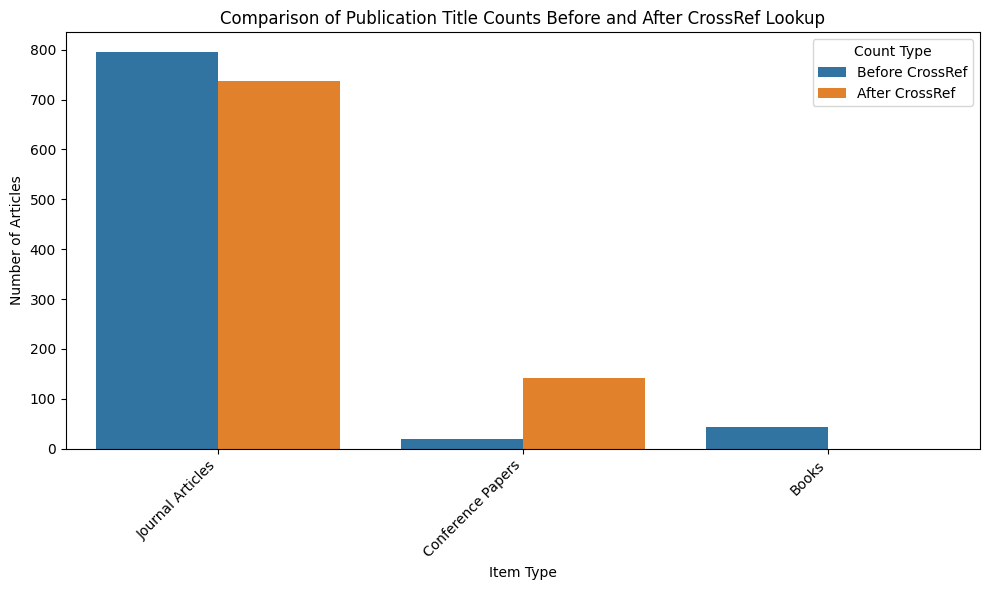

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x='Item Type', y='Count', hue='Count Type', data=comparison_df)
plt.title('Comparison of Publication Title Counts Before and After CrossRef Lookup')
plt.xlabel('Item Type')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Remaining books and journalArticles

Journal articles:

- DOI → /works/{doi} → container-title
- ISSN → /journals/{issn} → title
- No DOI/ISSN → /works?query.bibliographic=...&filter=type:journal-article,from-pub-date:...,until-pub-date:... best match title similarity

Books / book sections

- Title-based search filtered to type:book-chapter (fallback type:book-section, then type:book)
- chapter/book title similarity
-  “Publication Title” as a container hint (if present)


In [21]:
journal_articles_missing_official_title = pd.read_csv(os.path.join(local_root, 'journal_articles_missing_official_title.csv'))
print(len(journal_articles_missing_official_title))
books_missing_official_title = pd.read_csv(os.path.join(local_root, 'books_missing_official_title.csv'))
print(len(books_missing_official_title))

59
44


In [22]:
BOOKS_IN = os.path.join(local_root, "books_missing_official_title.csv")
JOURNALS_IN = os.path.join(local_root,"journal_articles_missing_official_title.csv")

BOOKS_OUT = "books_filled_official_title.csv"
JOURNALS_OUT = "journal_articles_filled_official_title.csv"

BOOKS_LEFT = "books_still_missing_official_title.csv"
JOURNALS_LEFT = "journal_articles_still_missing_official_title.csv"

NEW_COL = "Journal_official"
METHOD_COL = "Journal_official_method"
SOURCE_COL = "Journal_official_source"
SCORE_COL = "Journal_official_match_score"

CROSSREF_USER_AGENT = "JournalNameCleaner/1.0 (mailto:dianameda.rh@gmail.com)"
SLEEP_SECONDS = 0.2

MIN_TITLE_SCORE = 0.88

USE_CACHE = True
CACHE_PATH = "lookup_cache.json"

COL_DOI = "DOI"
COL_EXTRA = "Extra"
COL_ITEMTYPE = "Item Type"
COL_TITLE = "Title"
COL_YEAR = "Publication Year"
COL_PUBTITLE = "Publication Title"

DOI_RE = re.compile(r"\b10\.\d{4,9}/[-._;()/:A-Z0-9]+\b", re.I)

def normalize_doi(x):
    if x is None or (isinstance(x, float) and pd.isna(x)):
        return None
    d = str(x).strip()
    d = re.sub(r"^(https?://)?(dx\.)?doi\.org/", "", d, flags=re.I)
    d = re.sub(r"^doi:\s*", "", d, flags=re.I)
    d = d.strip()
    return d or None

def extract_doi_from_text(text):
    if text is None or (isinstance(text, float) and pd.isna(text)):
        return None
    m = DOI_RE.search(str(text))
    if not m:
        return None
    return m.group(0).rstrip(").,;]}>\"'")

def ensure_doi_column(df):
    """If DOI column is empty, try to extract DOI from Extra."""
    if COL_DOI not in df.columns:
        df[COL_DOI] = pd.NA
    if COL_EXTRA in df.columns:
        mask_blank = df[COL_DOI].isna() | df[COL_DOI].astype(str).str.strip().eq("")
        df.loc[mask_blank, COL_DOI] = df.loc[mask_blank, COL_EXTRA].apply(extract_doi_from_text)
    df["DOI_norm"] = df[COL_DOI].apply(normalize_doi)
    return df

def sim(a, b) -> float:
    if a is None or b is None:
        return 0.0
    a = str(a).strip().lower()
    b = str(b).strip().lower()
    if not a or not b:
        return 0.0
    return SequenceMatcher(None, a, b).ratio()

def first_nonempty(v):
    if isinstance(v, list):
        for x in v:
            if x and str(x).strip():
                return str(x).strip()
    elif isinstance(v, str) and v.strip():
        return v.strip()
    return None

def load_cache(path):
    if not USE_CACHE:
        return {}
    p = Path(path)
    if not p.exists():
        return {}
    try:
        return json.loads(p.read_text(encoding="utf-8"))
    except Exception:
        return {}

def save_cache(path, cache):
    if not USE_CACHE:
        return
    Path(path).write_text(json.dumps(cache, ensure_ascii=False, indent=2), encoding="utf-8")


# Online lookups
CSL_ACCEPT = "application/vnd.citationstyles.csl+json;q=1.0"

def doi_content_negotiation_csl(session: requests.Session, doi: str):
    """
    GET https://doi.org/{doi} with Accept: CSL-JSON
    Returns metadata JSON for many DOI agencies (not only Crossref).
    """
    if not doi:
        return None
    url = f"https://doi.org/{doi}"
    r = session.get(url, headers={"Accept": CSL_ACCEPT}, timeout=25, allow_redirects=True)
    if r.status_code == 404:
        return None
    r.raise_for_status()
    return r.json()

def official_name_from_csl(csl: dict, item_type: str):
    """
    JournalArticle -> container-title (journal)
    Book          -> title
    BookSection   -> container-title (book title), fallback title
    """
    if not csl:
        return None
    it = (str(item_type) if item_type is not None else "").strip().lower()

    container = first_nonempty(csl.get("container-title"))
    title = first_nonempty(csl.get("title"))

    if it == "journalarticle":
        return container
    if it == "book":
        return title or container
    if it == "booksection":
        return container or title
    # fallback
    return container or title

def crossref_search_work(session: requests.Session, title: str, year=None, cr_type: str | None = None, rows: int = 5):
    """
    Search Crossref works by bibliographic query (title), optionally filter by type and year.
    Returns (best_item, best_title_score) or (None, 0).
    """
    if not title or (isinstance(title, float) and pd.isna(title)):
        return None, 0.0

    params = {
        "query.bibliographic": str(title),
        "rows": rows
    }
    filters = []
    if cr_type:
        filters.append(f"type:{cr_type}")
    if year and not (isinstance(year, float) and pd.isna(year)):
        try:
            y = str(int(float(year)))
            filters.append(f"from-pub-date:{y}-01-01")
            filters.append(f"until-pub-date:{y}-12-31")
        except Exception:
            pass
    if filters:
        params["filter"] = ",".join(filters)

    r = session.get("https://api.crossref.org/works", params=params, timeout=25)
    if r.status_code == 404:
        return None, 0.0
    r.raise_for_status()
    msg = r.json().get("message", {})
    items = msg.get("items", []) or []
    if not items:
        return None, 0.0

    best = None
    best_score = 0.0
    for it in items:
        cand_title = first_nonempty(it.get("title"))
        s = sim(title, cand_title)
        if s > best_score:
            best_score = s
            best = it

    return best, best_score

def crossref_work_by_doi(session: requests.Session, doi: str):
    """Fetch full Crossref work record if it exists in Crossref."""
    if not doi:
        return None
    url = f"https://api.crossref.org/works/{quote(doi)}"
    r = session.get(url, timeout=25)
    if r.status_code == 404:
        return None
    r.raise_for_status()
    return r.json().get("message", {})

def official_name_from_crossref_message(msg: dict, item_type: str):
    """
    - journal articles: container-title
    - books: title
    - book sections: container-title (book title) fallback title
    """
    if not msg:
        return None
    it = (str(item_type) if item_type is not None else "").strip().lower()

    container = first_nonempty(msg.get("container-title"))
    title = first_nonempty(msg.get("title"))

    if it == "journalarticle":
        return container
    if it == "book":
        return title or container
    if it == "booksection":
        return container or title
    return container or title


def fill_official_names(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df = ensure_doi_column(df)

    for c in [NEW_COL, METHOD_COL, SOURCE_COL, SCORE_COL]:
        if c not in df.columns:
            df[c] = pd.NA

    session = requests.Session()
    session.headers.update({"User-Agent": CROSSREF_USER_AGENT})

    cache = load_cache(CACHE_PATH)
    missing_mask = df[NEW_COL].isna() | df[NEW_COL].astype(str).str.strip().eq("")

    for idx, row in tqdm(df[missing_mask].iterrows(), total=missing_mask.sum(), desc="Online lookup"):
        item_type = row.get(COL_ITEMTYPE, "")
        doi = row.get("DOI_norm")
        title = row.get(COL_TITLE, None)
        year = row.get(COL_YEAR, None)

        if doi:
            cache_key = f"csl:{doi}"
            csl = cache.get(cache_key)
            if csl is None:
                try:
                    csl = doi_content_negotiation_csl(session, doi)
                except Exception:
                    csl = None
                cache[cache_key] = csl
                time.sleep(SLEEP_SECONDS)

            official = official_name_from_csl(csl, str(item_type))
            if official:
                df.at[idx, NEW_COL] = official
                df.at[idx, METHOD_COL] = "doi_content_negotiation"
                df.at[idx, SOURCE_COL] = "doi.org (CSL-JSON)"
                df.at[idx, SCORE_COL] = 1.0
                continue

        # DOI missing metadata : Crossref title search
        it = str(item_type).strip().lower()
        if it == "journalarticle":
            cr_type = "journal-article"
        elif it == "book":
            cr_type = "book"
        elif it == "booksection":
            cr_type = "book-chapter"
        else:
            cr_type = None

        best, score = crossref_search_work(session, title=title, year=year, cr_type=cr_type, rows=5)
        time.sleep(SLEEP_SECONDS)

        if best and score >= MIN_TITLE_SCORE:
            found_doi = best.get("DOI")
            if found_doi:
                found_doi = normalize_doi(found_doi)
                cache_key = f"csl:{found_doi}"
                csl = cache.get(cache_key)
                if csl is None:
                    try:
                        csl = doi_content_negotiation_csl(session, found_doi)
                    except Exception:
                        csl = None
                    cache[cache_key] = csl
                    time.sleep(SLEEP_SECONDS)

                official = official_name_from_csl(csl, str(item_type))
                if official:
                    df.at[idx, NEW_COL] = official
                    df.at[idx, METHOD_COL] = "crossref_search_then_doi"
                    df.at[idx, SOURCE_COL] = "Crossref search + doi.org"
                    df.at[idx, SCORE_COL] = float(score)
                    continue

            official = first_nonempty(best.get("container-title")) or first_nonempty(best.get("title"))
            if official:
                df.at[idx, NEW_COL] = official
                df.at[idx, METHOD_COL] = "crossref_search_hit_fields"
                df.at[idx, SOURCE_COL] = "Crossref /works search"
                df.at[idx, SCORE_COL] = float(score)
                continue


    save_cache(CACHE_PATH, cache)
    return df





In [23]:
books_df = pd.read_csv(BOOKS_IN)
journals_df = pd.read_csv(JOURNALS_IN)

books_filled = fill_official_names(books_df)
journals_filled = fill_official_names(journals_df)

books_filled.to_csv(BOOKS_OUT, index=False)
journals_filled.to_csv(JOURNALS_OUT, index=False)


def still_missing(df):
    return df[df[NEW_COL].isna() | df[NEW_COL].astype(str).str.strip().eq("")].copy()

books_left = still_missing(books_filled)
journals_left = still_missing(journals_filled)

books_left.to_csv(BOOKS_LEFT, index=False)
journals_left.to_csv(JOURNALS_LEFT, index=False)

print("Books filled:", len(books_filled) - len(books_left), "still missing:", len(books_left))
print("Journals filled:", len(journals_filled) - len(journals_left), "still missing:", len(journals_left))
print("Outputs:", BOOKS_OUT, JOURNALS_OUT, BOOKS_LEFT, JOURNALS_LEFT)

/tmp/ipython-input-2173424440.py:56: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['10.4324/9781003432074-3' '10.1093/oso/9780198882077.003.0021'
 '10.1093/oso/9780198882077.003.0015' '10.1108/978-1-83753-536-120241010'
 '10.1007/978-981-97-9555-0_13' '10.4018/979-8-3693-4453-8.ch003' None
 '10.1007/978-3-031-61463-7_7' '10.4018/979-8-3693-0802-8.ch002'
 '10.1007/978-981-97-1814-6_17' '10.1007/978-3-031-52005-1_2'
 '10.1201/9781003424543-11' '10.1007/978-981-99-7947-9_2'
 '10.1007/978-981-19-5967-7_10' '10.1007/978-981-19-5967-7_23'
 '10.1007/978-981-16-7527-0_1' '10.1016/B978-0-12-823410-5.00006-1'
 '10.1007/978-3-031-13351-0_13' '10.1007/978-3-031-04286-7_26'
 '10.1007/978-981-19-5967-7_7' '10.4018/979-8-3693-8915-7.ch004'
 '10.4018/979-8-3373-5550-4.ch003' '10.4018/979-8-3373-5550-4.ch004'
 '10.4018/979-8-3373-5550-4.ch006' '10.4018/979-8-3373-0847-0.ch001'
 '10.4018/979-8-3373-0847-0.ch007' '10.4018

Books filled: 41 still missing: 3
Journals filled: 22 still missing: 37
Outputs: books_filled_official_title.csv journal_articles_filled_official_title.csv books_still_missing_official_title.csv journal_articles_still_missing_official_title.csv


In [25]:
PASS1_JOURNALS = os.path.join(local_root, "journalArticle_with_official_Publication_Title.csv")
PASS1_CONF     = os.path.join(local_root, "conferencePaper_with_official_Publication_Title.csv")
PASS1_BOOKS    = os.path.join(local_root, "book_with_official_Publication_Title.csv")

PASS2_BOOKS_FILLED    = os.path.join(local_root, "books_filled_official_title.csv")
PASS2_JOURNALS_FILLED = os.path.join(local_root, "journal_articles_filled_official_title.csv")

BOOKS_LEFT    = os.path.join(local_root, "books_still_missing_official_title.csv")
JOURNALS_LEFT = os.path.join(local_root, "journal_articles_still_missing_official_title.csv")

FINAL_WITH_OFFICIAL = os.path.join(local_root, "ALL_items_with_official_title.csv")

df_journal = pd.read_csv(PASS1_JOURNALS)
df_conf    = pd.read_csv(PASS1_CONF)
df_book    = pd.read_csv(PASS1_BOOKS)

df_books_filled    = pd.read_csv(PASS2_BOOKS_FILLED)
df_journals_filled = pd.read_csv(PASS2_JOURNALS_FILLED)

resolved_journal = pd.concat([df_journal, df_journals_filled], ignore_index=True)
resolved_book    = pd.concat([df_book, df_books_filled], ignore_index=True)
resolved_conf    = df_conf

final_resolved = pd.concat([resolved_journal, resolved_conf, resolved_book], ignore_index=True)
final_resolved.to_csv(FINAL_WITH_OFFICIAL, index=False)

books_left_df = pd.read_csv(BOOKS_LEFT)
journals_left_df = pd.read_csv(JOURNALS_LEFT)


In [26]:
print("Saved combined resolved file to:", FINAL_WITH_OFFICIAL)
print("\n--- Summary ---")
print("Resolved rows written:", len(final_resolved))
print("  Resolved journal articles:", len(resolved_journal))
print("  Resolved conference papers:", len(resolved_conf))
print("  Resolved books/sections:", len(resolved_book))

print("\nStill missing (kept as separate files):")
print("  Books still missing:", len(books_left_df), "->", BOOKS_LEFT)
print("  Journal articles still missing:", len(journals_left_df), "->", JOURNALS_LEFT)

Saved combined resolved file to: /content/review_data/ALL_items_with_official_title.csv

--- Summary ---
Resolved rows written: 1739
  Resolved journal articles: 855
  Resolved conference papers: 796
  Resolved books/sections: 88

Still missing (kept as separate files):
  Books still missing: 3 -> /content/review_data/books_still_missing_official_title.csv
  Journal articles still missing: 37 -> /content/review_data/journal_articles_still_missing_official_title.csv


# Load after manual input

In [43]:
final_df = pd.read_csv('/content/review_data/ALL_items_with_official_title.csv')
print(f"Df with {len(final_df)} rows and {len(final_df.columns)} columns.")


Df with 1740 rows and 94 columns.


In [60]:
print('Duplicated Key',len(final_df[final_df.duplicated(subset=['Key'])]))

Duplicated Key 900


In [61]:
final_df['Key'].nunique()

840

In [69]:
df_cleaned = final_df.drop_duplicates(subset=['Key'], keep='first').reset_index(drop=True)
df_cleaned.to_csv("ALL_items_with_official_title_without_duplicates.csv")

In [79]:
# merged_file initial file
#df_cleaned after adding journal names with python and manually

missing_df = merged_file[~merged_file["Key"].isin(df_cleaned["Key"])].copy()
print("Rows in merged_file:", len(merged_file))
print("Rows in df_840:", len(df_cleaned))
print("Difference rows:", len(missing_df))

missing_df = missing_df.reindex(columns=df_cleaned.columns)

missing_df.to_csv("missing_official.csv", index=False)

Rows in merged_file: 996
Rows in df_840: 840
Difference rows: 156


# Extra

In [97]:
CROSSREF_USER_AGENT = "VenueLookup/1.0 (mailto:dianameda.rh@gmail.com)"
SLEEP_SECONDS = 0.2
TOP_N = 5
PASS_SCORE = 0.92
REVIEW_SCORE = 0.85
KEY_COL = "Key"
TITLE_COL = "Title"


def openalex_search_best(title: str, session: requests.Session):
    """
    Returns (venue_name, doi, best_score) using OpenAlex search.
    Venue is taken from primary_location.source.display_name (if present).
    """
    if not title or not str(title).strip():
        return None, None, 0.0

    url = "https://api.openalex.org/works"
    params = {
        "search": title,
        "per_page": TOP_N,
        "select": "display_name,doi,primary_location,publication_year,type,type_crossref"
    }
    r = session.get(url, params=params, timeout=25)
    r.raise_for_status()
    results = (r.json() or {}).get("results", []) or []
    if not results:
        return None, None, 0.0

    best = None
    best_s = 0.0
    for it in results:
        cand_title = it.get("display_name")
        s = score(title, cand_title)
        if it.get("type_crossref") in ("proceedings-article", "book-chapter", "posted-content"):
            s += 0.01
        if s > best_s:
            best_s = s
            best = it

    if not best:
        return None, None, 0.0

    venue = None
    try:
        venue = best.get("primary_location", {}).get("source", {}).get("display_name")
    except Exception:
        venue = None

    doi = best.get("doi")
    # OpenAlex returns DOI as URL sometimes
    if isinstance(doi, str) and doi.lower().startswith("https://doi.org/"):
        doi = doi[16:]

    return venue, doi, float(best_s)

def crossref_search_best(title: str, session: requests.Session):
    """
    Returns (container_title, doi, best_score) using Crossref /works search.
    """
    if not title or not str(title).strip():
        return None, None, 0.0

    url = "https://api.crossref.org/works"
    params = {
        "query.bibliographic": title,
        "rows": TOP_N,
    }
    r = session.get(url, params=params, timeout=25)
    r.raise_for_status()
    items = (r.json() or {}).get("message", {}).get("items", []) or []
    if not items:
        return None, None, 0.0

    best = None
    best_s = 0.0
    for it in items:
        cand_title = None
        t = it.get("title")
        if isinstance(t, list) and t:
            cand_title = t[0]
        elif isinstance(t, str):
            cand_title = t

        s = score(title, cand_title)
        if s > best_s:
            best_s = s
            best = it

    if not best:
        return None, None, 0.0

    container = best.get("container-title")
    container_title = None
    if isinstance(container, list) and container:
        container_title = container[0]
    elif isinstance(container, str) and container.strip():
        container_title = container.strip()

    doi = best.get("DOI")
    return container_title, doi, float(best_s)

def lookup_venues_with_keys(df_in: pd.DataFrame) -> pd.DataFrame:
    """
    Input: df with columns [Key, Title]
    Output: df with columns [Key, Title, Venue_official, DOI_found, MatchScore, SourceUsed, Status]
    """
    if KEY_COL not in df_in.columns or TITLE_COL not in df_in.columns:
        raise ValueError(f"df_in must contain '{KEY_COL}' and '{TITLE_COL}'")

    s_openalex = requests.Session()
    s_openalex.headers.update({"User-Agent": CROSSREF_USER_AGENT})

    s_crossref = requests.Session()
    s_crossref.headers.update({"User-Agent": CROSSREF_USER_AGENT})

    out_rows = []
    for row in tqdm(df_in[[KEY_COL, TITLE_COL]].itertuples(index=False), total=len(df_in), desc="Looking up venues"):
        key = getattr(row, KEY_COL.replace(" ", "_"))
        title = getattr(row, TITLE_COL.replace(" ", "_"))

        venue, doi, best_s, source_used = None, None, 0.0, None

        # OpenAlex first
        try:
            venue, doi, best_s = openalex_search_best(title, s_openalex)
            source_used = "OpenAlex"
        except Exception:
            pass
        time.sleep(SLEEP_SECONDS)

        # Crossref fallback
        if not venue:
            try:
                venue2, doi2, s2 = crossref_search_best(title, s_crossref)
                if venue2 and s2 >= best_s:
                    venue, doi, best_s = venue2, doi2, s2
                    source_used = "Crossref"
            except Exception:
                pass
            time.sleep(SLEEP_SECONDS)

        if venue and best_s >= PASS_SCORE:
            status = "PASS"
        elif venue and best_s >= REVIEW_SCORE:
            status = "REVIEW"
        elif venue:
            status = "LOW_CONFIDENCE"
        else:
            status = "NOT_FOUND"

        out_rows.append({
            "Key": key,
            "Title": title,
            "Venue_official": venue,
            "DOI_found": doi,
            "MatchScore": best_s,
            "SourceUsed": source_used,
            "Status": status
        })

    return pd.DataFrame(out_rows)




In [101]:
df_conference = missing_df
venues_df = lookup_venues_with_keys(df_conference)
venues_df.to_csv("conference_title_to_venue_lookup.csv", index=False)

Looking up venues: 100%|██████████| 156/156 [01:46<00:00,  1.46it/s]


In [102]:
venues_df.columns


Index(['Key', 'Title', 'Venue_official', 'DOI_found', 'MatchScore',
       'SourceUsed', 'Status'],
      dtype='object')

In [103]:
venues_df[venues_df["Status"] == "PASS"]

,Key,Title,Venue_official,DOI_found,MatchScore,SourceUsed,Status
0,UPK756GC,Learning with Conversational AI and Personas: ...,International Conference on Computers in Educa...,10.58459/icce.2023.1390,1.0,OpenAlex,PASS
1,EXUBJUAV,AI in Cybersecurity Education- A Systematic Li...,2020 IEEE 20th International Conference on Adv...,10.1109/icalt49669.2020.00009,1.0,Crossref,PASS
2,NFSEWC96,Use of AI-driven Code Generation Models in Tea...,Proceedings of the 55th ACM Technical Symposiu...,10.1145/3626252.3630958,1.0,Crossref,PASS
3,BXM7WPLD,A Systematic Review of Generative Artificial I...,International Conference on Computers in Educa...,10.58459/icce.2023.1199,1.0,OpenAlex,PASS
4,XBCWBFRL,Artificial intelligence-assisted personalized ...,2021 International Conference on Advanced Lear...,10.1109/icalt52272.2021.00079,1.0,Crossref,PASS
...,...,...,...,...,...,...,...
150,SW6V4MIG,The Effect of Generative Artificial Intelligen...,Communications in computer and information sci...,10.1007/978-3-031-78255-8_21,1.0,OpenAlex,PASS
151,PYVA8FTL,Artificial Intelligence and Assistive Technolo...,Lecture notes in computer science,10.1007/978-3-031-93848-1_19,1.0,OpenAlex,PASS
153,UKCMRYLK,Understanding of Artificial Intelligence for I...,Lecture notes in networks and systems,10.1007/978-981-97-5035-1_3,1.0,OpenAlex,PASS
154,FN3MBP9H,Assessing AI Literacy: A Systematic Review of ...,Lecture notes in computer science,10.1007/978-3-032-01222-7_8,1.0,OpenAlex,PASS


In [109]:
len(venues_df[venues_df["Status"] == "PASS"]), venues_df["DOI_found"].nunique(), len(venues_df)

(135, 143, 156)

In [120]:
venues_unique = venues_df.drop_duplicates(subset=["Key", "Title"], keep="first")
missing_df2 = missing_df.merge(
    venues_unique[["Key", "Title", "Venue_official", "DOI_found"]],
    on=["Key"],
    how="left",
    suffixes=("", "_new")
)
jo_missing = missing_df2["Journal_official"].isna() | missing_df2["Journal_official"].astype(str).str.strip().eq("")
missing_df2.loc[jo_missing, "Journal_official"] = missing_df2.loc[jo_missing, "Venue_official"]

doi_missing = missing_df2["DOI"].isna() | missing_df2["DOI"].astype(str).str.strip().eq("")
missing_df2.loc[doi_missing, "DOI"] = missing_df2.loc[doi_missing, "DOI_found"]

missing_df2 = missing_df2.drop(columns=["Venue_official", "DOI_found"])
missing_df2.to_csv("missing_official_with_venues.csv", index=False)

In [123]:
FINAL_DF = pd.concat([df_cleaned, missing_df2], ignore_index=True)
FINAL_DF.to_csv("ALL_items_with_official_title.csv", index=False)

In [124]:
len(FINAL_DF)

996